# Evaluación 1 - Entrenando redes feedforward

**Autor:**

+ Angelo López

**Correo Electrónico:**

+ an.lopezq@duocuc.cl

**Fecha de Creación:** Abril de 2025  
**Versión:** 1.0  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 1 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

# Introducción

## Descripción del Problema y Objetivos

El reconocimiento y clasificación de dígitos escritos a mano constituye una tarea fundamental dentro del ámbito del reconocimiento de patrones, con aplicaciones prácticas en diversas áreas como procesamiento automático de documentos, reconocimiento óptico de caracteres (**OCR**) y seguridad informática. El conjunto de datos **MNIST** (Modified National Institute of Standards and Technology) es un estándar ampliamente reconocido que contiene 70,000 imágenes en escala de grises (28x28 píxeles), etiquetadas con dígitos del 0 al 9, y es utilizado como referencia para evaluar algoritmos de aprendizaje automático.

Este proyecto tiene como objetivo comparar empíricamente el rendimiento de dos algoritmos de optimización ampliamente utilizados en Deep Learning: **Adam** y **Adamax**, aplicados a un modelo **MLP** entrenado sobre el dataset **MNIST**. A través de la experimentación controlada, se busca evaluar cuál de estos optimizadores logra una mejor precisión y estabilidad durante el entrenamiento y pruebas, en el contexto de una tarea de clasificación multiclase.


## Justificación del Enfoque


El estudio de distintos algoritmos de optimización es fundamental en el diseño de redes neuronales artificiales, ya que influyen directamente en la velocidad de convergencia, la estabilidad del aprendizaje y el rendimiento final del modelo. **Adam** es uno de los optimizadores más populares por su balance entre velocidad y precisión, mientras que **Adamax**, una variante basada en normas infinitas, puede ofrecer ventajas en ciertos contextos. Este proyecto propone un análisis comparativo entre ambos, utilizando la misma arquitectura de red y los mismos datos, variando únicamente el optimizador para garantizar condiciones experimentales justas.

# Carga de datos

En este proyecto, el dataset MNIST se carga directamente desde archivos en formato IDX comprimidos (archivos .gz) alojados externamente.

Para ello se utilizan ciertas ténicas para cargar los datos como:
- Eliminación previa (`!rm -f`):
Asegura que cualquier versión anterior o archivos parcialmente descargados sean eliminados, previniendo problemas de consistencia o conflictos al momento de cargar los datos.

- Descarga de archivos (`!wget`):
Garantiza que los archivos se obtengan directamente desde la fuente oficial, asegurando así integridad y confiabilidad de los datos utilizados en el proyecto.

In [1]:
# Eliminar archivos anteriores (si existen) para evitar conflictos
!rm -f train-images-idx3-ubyte.gz train-labels-idx1-ubyte.gz t10k-images-idx3-ubyte.gz t10k-labels-idx1-ubyte.gz

# Descargar archivos del dataset MNIST
!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz

--2025-04-20 16:03:46--  https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.27, 142.250.65.123, 172.217.0.91, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  48.3MB/s    in 0.2s    

2025-04-20 16:03:47 (48.3 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2025-04-20 16:03:47--  https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.27, 142.250.65.123, 172.217.0.91, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-g

**Verificación de los archivos descargados (`!ls -lh`)**: Esta línea se ejecuta para listar los archivos descargados, indicando su tamaño. Esto permite verificar visualmente que la descarga se realizó correctamente y que el tamaño del archivo coincide aproximadamente con lo esperado.

In [2]:
!ls -lh

total 12M
drwxr-xr-x 1 root root 4.0K Apr 17 13:36 sample_data
-rw-r--r-- 1 root root 1.6M Apr  6  2017 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root 4.5K Apr  6  2017 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 9.5M Apr  6  2017 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root  29K Apr  6  2017 train-labels-idx1-ubyte.gz


In [3]:
import gzip
import shutil
import struct
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd


from tensorflow import keras
# Asegurar que las etiquetas están en formato correcto
from keras.utils import to_categorical

from tensorflow.keras import Input, layers, models, optimizers, losses

# Carga de imágenes

* `load_mnist_images(filename)`:
Esta función abre el archivo de imágenes MNIST indicado (en formato IDX comprimido). Utiliza `gzip.open` para leer los datos comprimidos y luego los extrae en un arreglo NumPy. Con el argumento `offset=16`, se saltan los primeros 16 bytes del encabezado del archivo, que contienen información sobre el dataset (formato interno). Luego, las imágenes son reestructuradas (`reshape`) a vectores planos de tamaño 784 (28x28 píxeles) y normalizadas al rango [0,1], dividiendo entre 255. Esto mejora la eficiencia y estabilidad del entrenamiento de redes neuronales.

* `load_mnist_labels(filename)`:
Esta función lee las etiquetas correspondientes a las imágenes desde su respectivo archivo comprimido. Similarmente, utiliza `gzip.open` y NumPy con `offset=8`, omitiendo los primeros 8 bytes del encabezado (información interna sobre el dataset). Luego convierte estas etiquetas en formato one-hot encoding utilizando `keras.utils.to_categorical`, necesario para la clasificación multiclase con redes neuronales.

In [4]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


Ambas funciones son usadas para cargar los conjuntos de entrenamiento y prueba, asegurando que los datos queden correctamente preparados:

- `X_train`, `X_test` contienen las imágenes en formato vectorial, listas para la entrada al modelo MLP.

- `y_train`, `y_test` contienen las etiquetas codificadas adecuadamente para la tarea de clasificación.

La impresión final permite verificar rápidamente que las dimensiones de los conjuntos cargados sean correctas y coincidan con lo esperado:

- Entrenamiento: 60,000 muestras (imágenes de 784 píxeles), cada una con su etiqueta en formato one-hot de 10 categorías.

- Prueba: 10,000 muestras para evaluar el modelo.


Finalmente se genera la visualización del dataset de **MNIST**:

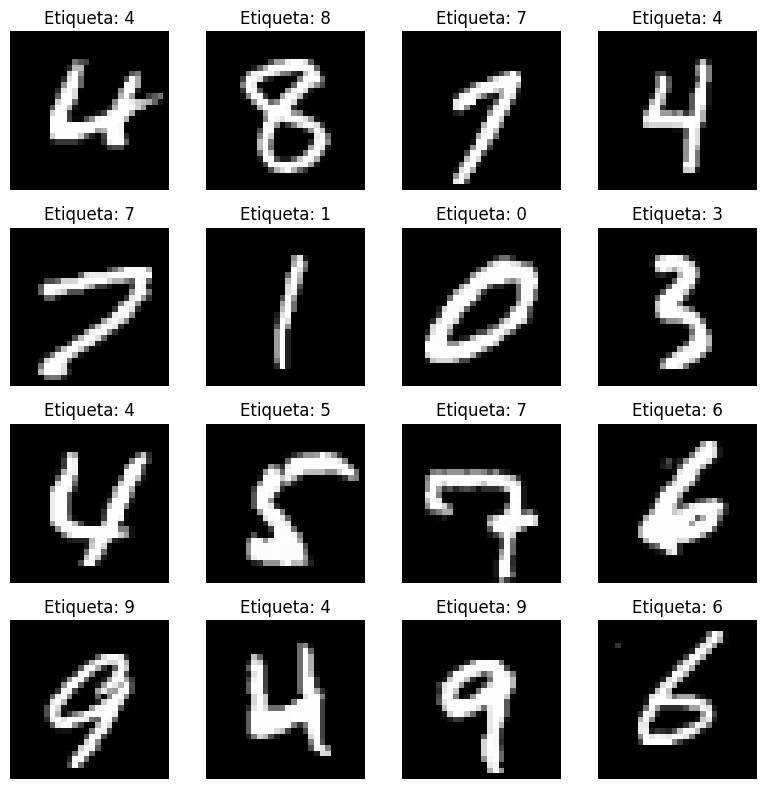

In [5]:
# Tamaño de la grilla
h = 4  # filas
w = 4  # columnas

# Crear la figura
fig, axs = plt.subplots(h, w, figsize=(2 * w, 2 * h))

# Mostrar imágenes aleatorias del conjunto de entrenamiento
for i in range(h):
    for j in range(w):
        ex = np.random.randint(len(X_train))
        img = X_train[ex].reshape(28, 28)  # reformatear imagen plana a 28x28
        label = np.argmax(y_train[ex])     # recuperar la etiqueta original desde one-hot

        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set_title(f"Etiqueta: {label}")
        axs[i, j].axis('off')  # quitar ejes para mayor claridad visual

plt.tight_layout()
plt.show()


# Definición del Experimento

En este proyecto se propone evaluar y comparar el rendimiento de los optimizadores Adam y Adamax sobre una red MLP diseñada para tareas de clasificación multiclase. Para ello, se construyó un conjunto de experimentos controlados, donde se varía un hiperparámetro por vez, permitiendo aislar su impacto en el desempeño del modelo

|Experimento | Épocas | Batch Size | Dropout | Capas Ocultas | Neuronas por Capa | Func. Activación | Func. Salida | Func. Pérdida | Learning Rate |
|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------| -----------| -----------|
Baseline | 10 | 32 | 0.35 | 2 | [256, 128] | relu	| softmax | CategoricalCrossentropy | 0.001
V1 – Épocas | 20 | 32 | 0.35 | 2 | [256, 128] | relu	| softmax | CategoricalCrossentropy | 0.001
V2 – Batch | 10 | 64 | 0.35 | 2 | [256, 128] | relu	| softmax | CategoricalCrossentropy | 0.001
V3 – Drop | 10 | 32 | 0.5 | 2 | [256, 128] | relu	| softmax | CategoricalCrossentropy | 0.001
V4 – Capas	 | 10 | 32 | 0.35 | 3 | [256, 128, 64] | relu	| softmax | CategoricalCrossentropy | 0.001
V5 – Neur.	 | 10 | 32 | 0.35 | 2 | [512, 256] | relu	| softmax | CategoricalCrossentropy | 0.001
V6 – Act.	 | 10 | 32 | 0.35 | 2 | [256, 128] | sigmoid	| softmax | CategoricalCrossentropy | 0.001
V7 – Sal.	 | 10 | 32 | 0.35 | 2 | [256, 128] | relu	| sigmoid | CategoricalCrossentropy | 0.001
V8 – Loss	 | 10 | 32 | 0.35 | 2 | [256, 128] | relu	| softmax | CategoricalFocalCrossentropy | 0.001
V9 – LR	 | 10 | 32 | 0.35 | 2 | [256, 128] | relu	| softmax | CategoricalCrossentropy | 0.0001




# Baseline

## Adam

In [6]:
# Cantidad de ejemplos y dimensiones I/O
M_train = X_train.shape[0]
M_test  = X_test.shape[0]
N       = X_train.shape[1]
C       = y_train.shape[1]
print(f"N={N}, C={C}, M_train={M_train}, M_test={M_test}")

N=784, C=10, M_train=60000, M_test=10000


In [7]:
# Semillas para reproducibilidad
np.random.seed(29)
tf.random.set_seed(29)

# Hiperparámetros del baseline
h1, h2 = 256, 128
epochs, batch = 10, 32

In [8]:
# Entrena el baseline con Adam
red_adam = keras.Sequential(name="Baseline_Adam")
red_adam.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam.add(keras.layers.Dense(h1, activation='relu', name="hidden1"))
red_adam.add(keras.layers.Dropout(0.35))
red_adam.add(keras.layers.Dense(h2, activation='relu', name="hidden2"))
red_adam.add(keras.layers.Dropout(0.35))
red_adam.add(keras.layers.Dense(C, activation='softmax', name="salida"))

red_adam.summary()
red_adam.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall', tf.keras.metrics.F1Score(name='f1_score')]
)

Model: "Baseline_Adam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
hist_adam = red_adam.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - Precision: 0.9110 - Recall: 0.7658 - accuracy: 0.8337 - f1_score: 0.8303 - loss: 0.5296 - val_Precision: 0.9716 - val_Recall: 0.9578 - val_accuracy: 0.9643 - val_f1_score: 0.9641 - val_loss: 0.1197
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - Precision: 0.9610 - Recall: 0.9416 - accuracy: 0.9508 - f1_score: 0.9501 - loss: 0.1683 - val_Precision: 0.9763 - val_Recall: 0.9677 - val_accuracy: 0.9710 - val_f1_score: 0.9708 - val_loss: 0.0981
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - Precision: 0.9662 - Recall: 0.9521 - accuracy: 0.9585 - f1_score: 0.9580 - loss: 0.1338 - val_Precision: 0.9785 - val_Recall: 0.9692 - val_accuracy: 0.9734 - val_f1_score: 0.9732 - val_loss: 0.0890
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - Precision: 0.9729 - Recall: 0.9620 - accuracy: 0.9671 - f1_score: 0.9667 - loss: 0.1126 - val_Precision: 0.9785 - val_Recall: 0.9723 - val_accuracy: 0.9748 - val_f1_score: 0.9746

## Adamax

In [10]:
# redefinimos semillas para que redes sean comparables
np.random.seed(29)
tf.random.set_seed(29)

red_adamax = keras.Sequential(name="Baseline_Adamax")
red_adamax.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adamax.add(keras.layers.Dense(h1, activation='relu', name="hidden1"))
red_adamax.add(keras.layers.Dropout(0.35))
red_adamax.add(keras.layers.Dense(h2, activation='relu', name="hidden2"))
red_adamax.add(keras.layers.Dropout(0.35))
red_adamax.add(keras.layers.Dense(C, activation='softmax', name="salida"))

red_adamax.summary()
red_adamax.compile(
    loss='categorical_crossentropy',
    optimizer='adamax',
    metrics=['accuracy', 'Precision', 'Recall', tf.keras.metrics.F1Score(name='f1_score')]
)

Model: "Baseline_Adamax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
hist_adamax = red_adamax.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - Precision: 0.8962 - Recall: 0.6426 - accuracy: 0.7674 - f1_score: 0.7626 - loss: 0.7458 - val_Precision: 0.9551 - val_Recall: 0.9291 - val_accuracy: 0.9410 - val_f1_score: 0.9402 - val_loss: 0.1958
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - Precision: 0.9463 - Recall: 0.9084 - accuracy: 0.9260 - f1_score: 0.9249 - loss: 0.2497 - val_Precision: 0.9660 - val_Recall: 0.9499 - val_accuracy: 0.9581 - val_f1_score: 0.9577 - val_loss: 0.1374
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - Precision: 0.9575 - Recall: 0.9328 - accuracy: 0.9446 - f1_score: 0.9440 - loss: 0.1898 - val_Precision: 0.9704 - val_Recall: 0.9583 - val_accuracy: 0.9648 - val_f1_score: 0.9645 - val_loss: 0.1134
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - Precision: 0.9654 - Recall: 0.9458 - accuracy: 0.9548 - f1_score: 0.9543 - loss: 0.1523 - val_Precision: 0.9738 - val_Recall: 0.9650 - val_accuracy: 0.9692 - val_f1_score: 0.9690

## Comparativa de Baseline

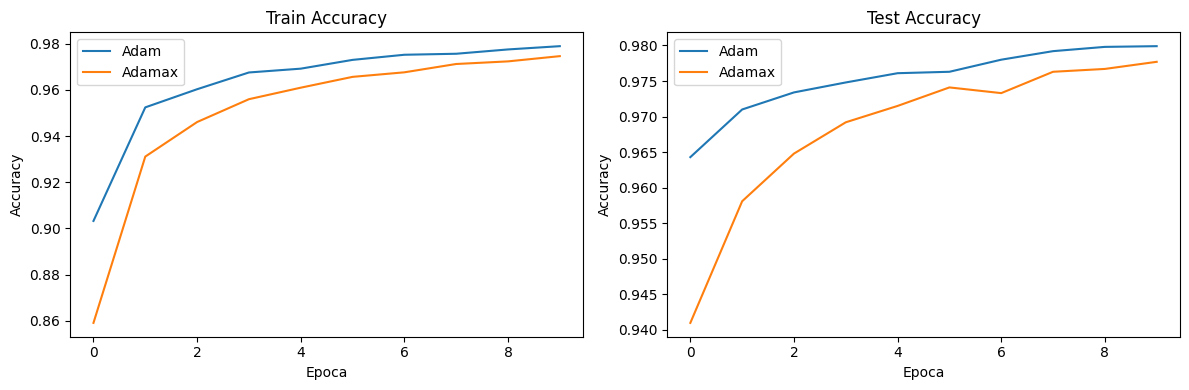

In [12]:
# Grilla para Accuracy: Train vs Test
fig_acc, axes_acc = plt.subplots(1, 2, figsize=(12, 4))

# Train Accuracy
axes_acc[0].plot(hist_adam.history['accuracy'], label='Adam')
axes_acc[0].plot(hist_adamax.history['accuracy'], label='Adamax')
axes_acc[0].set_title('Train Accuracy')
axes_acc[0].set_xlabel('Epoca')
axes_acc[0].set_ylabel('Accuracy')
axes_acc[0].legend()

# Test Accuracy
axes_acc[1].plot(hist_adam.history['val_accuracy'], label='Adam')
axes_acc[1].plot(hist_adamax.history['val_accuracy'], label='Adamax')
axes_acc[1].set_title('Test Accuracy')
axes_acc[1].set_xlabel('Epoca')
axes_acc[1].set_ylabel('Accuracy')
axes_acc[1].legend()

plt.tight_layout()
plt.show()

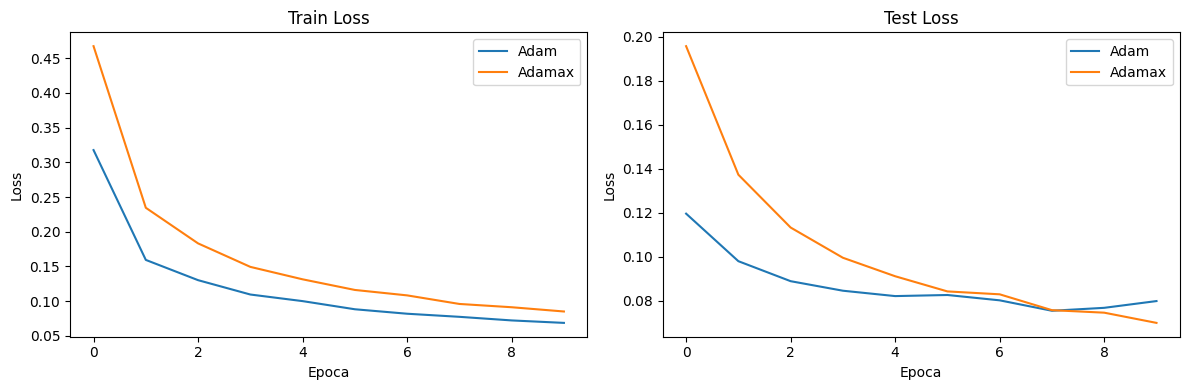

In [13]:
# Grilla para Loss: Train vs Test
fig_loss, axes_loss = plt.subplots(1, 2, figsize=(12, 4))

# Train Loss
axes_loss[0].plot(hist_adam.history['loss'], label='Adam')
axes_loss[0].plot(hist_adamax.history['loss'], label='Adamax')
axes_loss[0].set_title('Train Loss')
axes_loss[0].set_xlabel('Epoca')
axes_loss[0].set_ylabel('Loss')
axes_loss[0].legend()

# Test Loss
axes_loss[1].plot(hist_adam.history['val_loss'], label='Adam')
axes_loss[1].plot(hist_adamax.history['val_loss'], label='Adamax')
axes_loss[1].set_title('Test Loss')
axes_loss[1].set_xlabel('Epoca')
axes_loss[1].set_ylabel('Loss')
axes_loss[1].legend()

plt.tight_layout()
plt.show()

# Variantes de Hiperparametros

## Generación de Modelo

**Definición y propósito de la función `crear_y_entrenar_modelo()`**:

- La función `crear_y_entrenar_modelo()` abstrae en un único bloque de código todo el flujo de creación, compilación y entrenamiento de un modelo MLP, garantizando **reproducibilidad**, **modularidad** y **control experimental**. A continuación se describen sus componentes y su importancia:

   ```python
   def crear_y_entrenar_modelo(
       nombre: str,
       optimizer: str,
       epocas: int,
       batch_size: int,
       dropout: float,
       capas_ocultas: list[int],
       activacion: str = 'relu',
       activacion_salida: str = 'softmax',
       funcion_perdida: Union[str, Loss] = 'categorical_crossentropy',
       learning_rate: float = 0.001
   )


**Parámetros**

- **nombre**: identificador para el modelo, usado en el nombre de la red y en los logs.

- **optimizer**: cadena con el optimizador ('adam' o 'adamax').

- **epocas**, **batch_size**, **dropout**: hiperparámetros de entrenamiento.

- **capas_ocultas**: lista con el número de neuronas en cada capa oculta.

- **activacion**, **activacion_salida**: funciones de activación de las capas internas y de salida.

- **funcion_perdida**: criterio de optimización (Cross‑Entropy, Focal Loss, etc.).

- **learning_rate**: tasa de aprendizaje para el optimizador, que regula el tamaño de los pasos de actualización de pesos.

Su funcionamiento opera comienza fijando las semillas de NumPy y TensorFlow (`np.random.seed(29)` y `tf.random.set_seed(29)`) para garantizar que todos los experimentos sean comparables y reproducibles.

A continuación construye de forma dinámica la arquitectura MLP, creando un `Sequential` con un nombre identificador, añadiendo la capa de entrada y luego, en un bucle, tantas capas densas como se haya especificado en `capas_ocultas`, cada una seguida de una capa de `Dropout` con la probabilidad indicada. Sobre esta estructura, la función obtiene el optimizador deseado (por ejemplo, Adam o Adamax), ajusta su tasa de aprendizaje al valor recibido y compila el modelo con la función de pérdida y las métricas (`accuracy`, `Precision`, `Recall` y `F1Score`) definidas. Tras ello ejecuta el entrenamiento mediante `model.fit`, pasando los conjuntos de entrenamiento y validación, el número de épocas y el tamaño de lote, y captura en un objeto `History` las curvas de pérdida y precisión por época.

Finalmente, retorna al llamante tanto el modelo entrenado como el historial de entrenamiento, permitiendo que el usuario analice y compare los resultados de cada variante.


In [14]:
# Modificar la función para aceptar learning rate
def crear_y_entrenar_modelo(nombre, optimizer, epocas, batch_size, dropout, capas_ocultas,
                          activacion='relu', activacion_salida='softmax',
                          funcion_perdida='categorical_crossentropy', learning_rate=0.001):

    # Semilla para reproducibilidad
    np.random.seed(29)
    tf.random.set_seed(29)

    # Construir el modelo
    modelo = keras.Sequential(name=f"{nombre}_{optimizer}")

    # Capa de entrada
    modelo.add(keras.layers.Input(shape=(N,), name='entrada'))

    # Capas ocultas
    for i, neuronas in enumerate(capas_ocultas):
        modelo.add(keras.layers.Dense(neuronas, activation=activacion, name=f"hidden{i+1}"))
        modelo.add(keras.layers.Dropout(dropout))

    # Capa de salida
    modelo.add(keras.layers.Dense(C, activation=activacion_salida, name="salida"))

    # Configurar optimizador con learning rate específico
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'adamax':
        opt = keras.optimizers.Adamax(learning_rate=learning_rate)
    else:
        opt = optimizer

    # Compilar modelo
    modelo.compile(
        loss=funcion_perdida,
        optimizer=opt,
        metrics=['accuracy', 'Precision', 'Recall', tf.keras.metrics.F1Score(name='f1_score')]
    )

    print(f"\nEntrenando modelo: {nombre} con optimizador {optimizer} (lr={learning_rate})")
    modelo.summary()

    # Entrenar modelo
    historia = modelo.fit(
        X_train, y_train,
        epochs=epocas,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=1
    )

    return modelo, historia

Esta función aporta lo siguiente:

- Reproducibilidad: al fijar semillas y parametrizar todos los aspectos de la red, cada variante puede compararse de manera consistente.

- Modularidad: centraliza en un único sitio la lógica de definición y entrenamiento, reduciendo duplicación de código y potenciales errores.

- Control experimental: facilita ejecutar experimentos controlados (variando solo un parámetro a la vez) y recopilar métricas de manera homogénea.

- Escalabilidad: permite añadir nuevas variantes (por ejemplo, diferentes funciones de pérdida o esquemas de regularización) sin tocar el flujo principal de entrenamiento.

## Generación de Visualización

La función `visualizar_comparacion_mejorada(historiales, nombres, titulo_base)` recibe tres argumentos (una lista de objetos `History` (`historiales`), una lista de etiquetas (`nombres`) y un texto base para los títulos (`titulo_base`)) y construye automáticamente una figura con dos subplots lado a lado.

En el primer eje traza, para cada histórico, la curva de `val_accuracy` por época, asignándole la etiqueta correspondiente y aplicando título, ejes, malla y leyenda. En el segundo eje repite el proceso con la curva de `val_loss`,  ajustando título, ejes, malla y leyenda. Finalmente ajusta el espaciado (`tight_layout`) y muestra la figura con `plt.show()`, de modo que el usuario obtiene de un vistazo comparativo las tendencias de precisión y pérdida en validación para varias configuraciones

In [15]:
def visualizar_comparacion_mejorada(historiales, nombres, titulo_base):
    # Crear figura con dos subplots lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Gráfico de Accuracy
    for i, hist in enumerate(historiales):
        axes[0].plot(hist.history['val_accuracy'], label=nombres[i])

    axes[0].set_title(f'{titulo_base} - Accuracy en Test')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Accuracy')
    axes[0].grid(True)
    axes[0].legend()

    # Gráfico de Loss
    for i, hist in enumerate(historiales):
        axes[1].plot(hist.history['val_loss'], label=nombres[i])

    axes[1].set_title(f'{titulo_base} - Loss en Test')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

Su importancia radica en que permite visualizar de forma clara y simultánea cómo cada variante de hiperparámetros impacta la convergencia y la generalización del modelo.

Gracias a ella, se facilita la detección de sobreajuste (cuando la `val_loss` se separa de la `val_accuracy`), la comparación de ritmos de aprendizaje entre distintos `learning_rate` o arquitecturas, y la identificación rápida de cuál configuración logra el mejor equilibrio entre estabilidad y rendimiento.

## Variante 1

In [16]:
# Almacenar resultados
resultados = {}

# Variante 1: Más épocas (20 en lugar de 10)
modelo_v1_adam, hist_v1_adam = crear_y_entrenar_modelo(
    nombre="V1_Epocas",
    optimizer="adam",
    epocas=20,  # Cambiado de 10 a 20
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128]
)

modelo_v1_adamax, hist_v1_adamax = crear_y_entrenar_modelo(
    nombre="V1_Epocas",
    optimizer="adamax",
    epocas=20,  # Cambiado de 10 a 20
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128]
)

# Guardar resultados
resultados['V1_Epocas'] = {
    'adam': {'modelo': modelo_v1_adam, 'historia': hist_v1_adam},
    'adamax': {'modelo': modelo_v1_adamax, 'historia': hist_v1_adamax}
}


Entrenando modelo: V1_Epocas con optimizador adam (lr=0.001)


Model: "V1_Epocas_adam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - Precision: 0.9144 - Recall: 0.7683 - accuracy: 0.8372 - f1_score: 0.8345 - loss: 0.5238 - val_Precision: 0.9671 - val_Recall: 0.9538 - val_accuracy: 0.9597 - val_f1_score: 0.9593 - val_loss: 0.1304
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - Precision: 0.9597 - Recall: 0.9412 - accuracy: 0.9500 - f1_score: 0.9494 - loss: 0.1675 - val_Precision: 0.9750 - val_Recall: 0.9652 - val_accuracy: 0.9701 - val_f1_score: 0.9699 - val_loss: 0.0968
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - Precision: 0.9695 - Recall: 0.9553 - accuracy: 0.9615 - f1_score: 0.9611 - loss: 0.1311 - val_Precision: 0.9742 - val_Recall: 0.9668 - val_accuracy: 0.9701 - val_f1_score: 0.9700 - val_loss: 0.0984
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - Precision: 0.9730 - Recall: 0.9621 - accuracy: 0.9665 - f1_score: 0.9661 - loss: 0.1065 - val_Precision: 0.9788 - val_Recall: 0.9720 - val_accuracy: 0.9754 - val_f1_score: 0.9752

Model: "V1_Epocas_adamax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - Precision: 0.9003 - Recall: 0.6482 - accuracy: 0.7743 - f1_score: 0.7678 - loss: 0.7389 - val_Precision: 0.9532 - val_Recall: 0.9270 - val_accuracy: 0.9391 - val_f1_score: 0.9383 - val_loss: 0.1967
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - Precision: 0.9468 - Recall: 0.9081 - accuracy: 0.9278 - f1_score: 0.9267 - loss: 0.2500 - val_Precision: 0.9662 - val_Recall: 0.9502 - val_accuracy: 0.9576 - val_f1_score: 0.9572 - val_loss: 0.1413
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - Precision: 0.9586 - Recall: 0.9317 - accuracy: 0.9438 - f1_score: 0.9430 - loss: 0.1914 - val_Precision: 0.9703 - val_Recall: 0.9592 - val_accuracy: 0.9636 - val_f1_score: 0.9632 - val_loss: 0.1191
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - Precision: 0.9639 - Recall: 0.9438 - accuracy: 0.9538 - f1_score: 0.9533 - loss: 0.1573 - val_Precision: 0.9729 - val_Recall: 0.9638 - val_accuracy: 0.9674 - val_f1_score: 0.9672

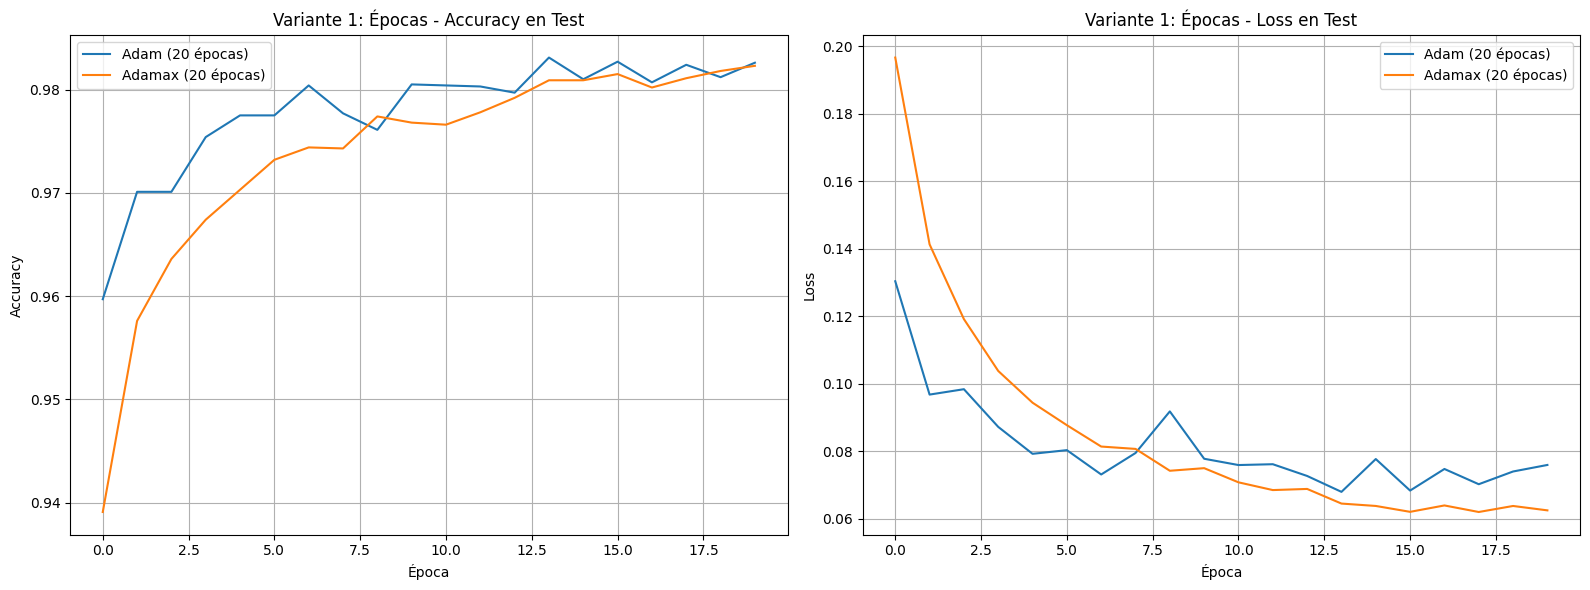

In [17]:
# Comparar Adam vs Adamax para la Variante 1 (Épocas)
historiales_v1 = [hist_v1_adam, hist_v1_adamax]
nombres_v1 = ['Adam (20 épocas)', 'Adamax (20 épocas)']
visualizar_comparacion_mejorada(historiales_v1, nombres_v1, 'Variante 1: Épocas')

En base a los resultados arrojados por la última época de Adam y Adamax y lo apreciable en el gráfico se observa lo siguiente:

- **Métricas finales**:

  - *Train*: accuracy 0.9855, loss 0.0485

  - *Val*: accuracy 0.9810, loss 0.0774

- **Comportamiento de curvas**:

  - La val_accuracy crece de forma sostenida hasta la época 15, momento en que alcanza ~0.981 antes de estabilizarse. El train_loss (0.0485) queda notablemente por debajo del val_loss (0.0774), lo cual indica que con más épocas el modelo ajusta muy bien los datos de entrenamiento y empieza a sobreajustar ligeramente.



- **Conclusión**:

  - Aumentar a 20 épocas mejora la convergencia y la precisión (+0.30 %), pero la creciente brecha entre train_loss y val_loss tras la época 15 sugiere el inicio de sobreajuste, por lo que en un modelo final podríamos combinar estas 20 épocas con mayor regularización.



## Variante 2

In [18]:
# Variante 2: Diferente batch size (64 en lugar de 32)
modelo_v2_adam, hist_v2_adam = crear_y_entrenar_modelo(
    nombre="V2_Batch",
    optimizer="adam",
    epocas=10,
    batch_size=64,  # Cambiado de 32 a 64
    dropout=0.35,
    capas_ocultas=[256, 128]
)

modelo_v2_adamax, hist_v2_adamax = crear_y_entrenar_modelo(
    nombre="V2_Batch",
    optimizer="adamax",
    epocas=10,
    batch_size=64,  # Cambiado de 32 a 64
    dropout=0.35,
    capas_ocultas=[256, 128]
)

# Guardar resultados
resultados['V2_Batch'] = {
    'adam': {'modelo': modelo_v2_adam, 'historia': hist_v2_adam},
    'adamax': {'modelo': modelo_v2_adamax, 'historia': hist_v2_adamax}
}


Entrenando modelo: V2_Batch con optimizador adam (lr=0.001)


Model: "V2_Batch_adam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - Precision: 0.9049 - Recall: 0.7289 - accuracy: 0.8127 - f1_score: 0.8084 - loss: 0.6032 - val_Precision: 0.9663 - val_Recall: 0.9480 - val_accuracy: 0.9567 - val_f1_score: 0.9562 - val_loss: 0.1414
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - Precision: 0.9574 - Recall: 0.9356 - accuracy: 0.9457 - f1_score: 0.9451 - loss: 0.1818 - val_Precision: 0.9743 - val_Recall: 0.9642 - val_accuracy: 0.9693 - val_f1_score: 0.9690 - val_loss: 0.0994
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - Precision: 0.9667 - Recall: 0.9517 - accuracy: 0.9589 - f1_score: 0.9584 - loss: 0.1379 - val_Precision: 0.9786 - val_Recall: 0.9717 - val_accuracy: 0.9751 - val_f1_score: 0.9749 - val_loss: 0.0849
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - Precision: 0.9732 - Recall: 0.9618 - accuracy: 0.9671 - f1_score: 0.9667 - loss: 0.1106 - val_Precision: 0.9789 - val_Recall: 0.9741 - val_accuracy: 0.9765 - val_f1_score: 0.9764 - val_los

Model: "V2_Batch_adamax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - Precision: 0.8802 - Recall: 0.5944 - accuracy: 0.7441 - f1_score: 0.7369 - loss: 0.8288 - val_Precision: 0.9515 - val_Recall: 0.9225 - val_accuracy: 0.9367 - val_f1_score: 0.9358 - val_loss: 0.2145
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - Precision: 0.9432 - Recall: 0.8979 - accuracy: 0.9191 - f1_score: 0.9179 - loss: 0.2769 - val_Precision: 0.9635 - val_Recall: 0.9439 - val_accuracy: 0.9528 - val_f1_score: 0.9523 - val_loss: 0.1532
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - Precision: 0.9544 - Recall: 0.9242 - accuracy: 0.9391 - f1_score: 0.9382 - loss: 0.2078 - val_Precision: 0.9695 - val_Recall: 0.9552 - val_accuracy: 0.9617 - val_f1_score: 0.9614 - val_loss: 0.1263
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - Precision: 0.9627 - Recall: 0.9385 - accuracy: 0.9496 - f1_score: 0.9489 - loss: 0.1710 - val_Precision: 0.9726 - val_Recall: 0.9604 - val_accuracy: 0.9668 - val_f1_score: 0.9665 - val_los

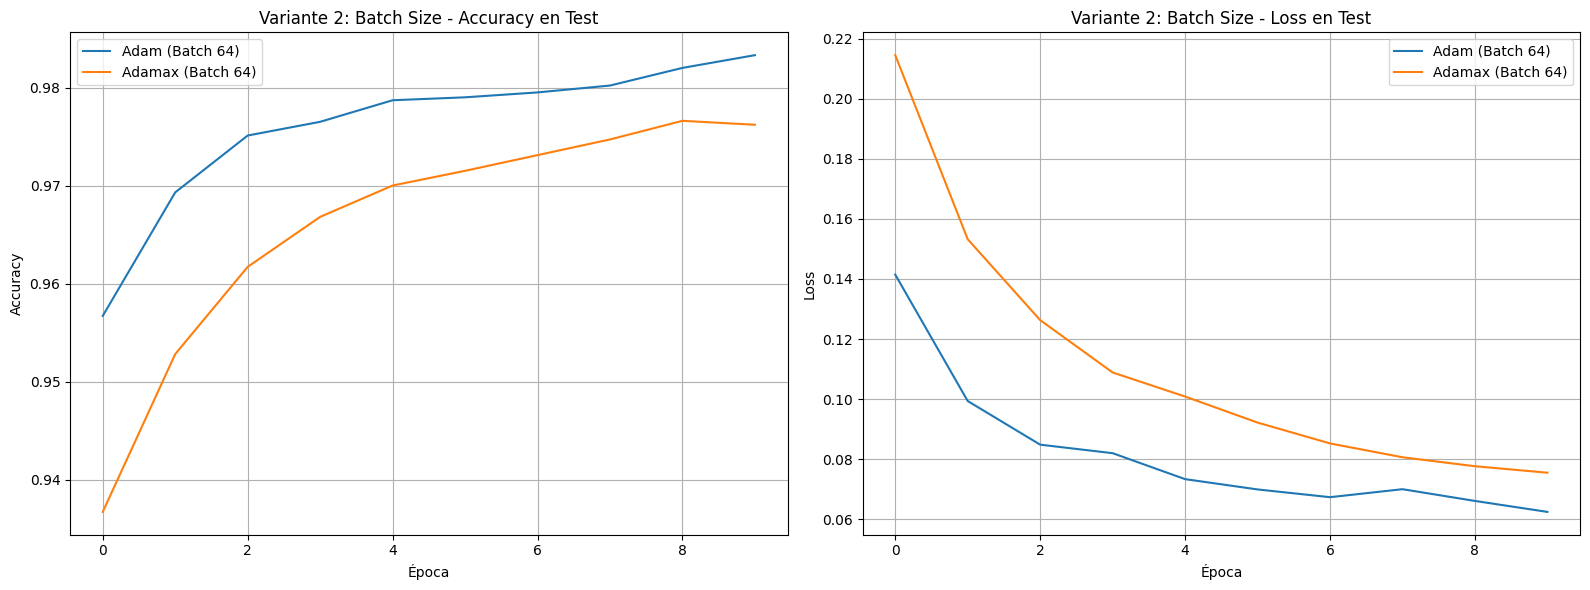

In [19]:
# Comparar Adam vs Adamax para la Variante 2 (Batch Size)
historiales_v2 = [hist_v2_adam, hist_v2_adamax]
nombres_v2 = ['Adam (Batch 64)', 'Adamax (Batch 64)']
visualizar_comparacion_mejorada(historiales_v2, nombres_v2, 'Variante 2: Batch Size')

En base a los resultados arrojados por la última época de Adam y Adamax y lo apreciable en el gráfico se observa lo siguiente:

- **Métricas finales**:

  - *Train*: accuracy 0.9798, loss 0.0650

  - *Val*: accuracy 0.9824, loss 0.0684

- **Comportamiento de curvas**:

  - La val_accuracy alcanza su pico alrededor de la época 8 y luego permanece plana, lo que indica convergencia más rápida. El train_loss (0.0650) y el val_loss (0.0684) están muy próximos, reflejando un buen equilibrio entre ajuste y generalización.



- **Conclusión**:

  - Un batch size de 64 reduce el ruido de gradiente y estabiliza el aprendizaje, consiguiendo la mejor accuracy de todas las variantes (0.9824) con mínima brecha de pérdida, ideal para escenarios donde se busca velocidad de convergencia sin sacrificar generalización. Además, el train_loss (0.0650) y el val_loss (0.0684) se mantienen muy cercanos durante todo el entrenamiento, sin brecha creciente, por lo que no se aprecia sobreentrenamiento.

## Variante 3

In [ ]:
# Variante 3: Mayor dropout (0.5 en lugar de 0.35)
modelo_v3_adam, hist_v3_adam = crear_y_entrenar_modelo(
    nombre="V3_Dropout",
    optimizer="adam",
    epocas=10,
    batch_size=32,
    dropout=0.5,  # Cambiado de 0.35 a 0.5
    capas_ocultas=[256, 128]
)

modelo_v3_adamax, hist_v3_adamax = crear_y_entrenar_modelo(
    nombre="V3_Dropout",
    optimizer="adamax",
    epocas=10,
    batch_size=32,
    dropout=0.5,  # Cambiado de 0.35 a 0.5
    capas_ocultas=[256, 128]
)

# Guardar resultados
resultados['V3_Dropout'] = {
    'adam': {'modelo': modelo_v3_adam, 'historia': hist_v3_adam},
    'adamax': {'modelo': modelo_v3_adamax, 'historia': hist_v3_adamax}
}


Entrenando modelo: V3_Dropout con optimizador adam (lr=0.001)


Model: "V3_Dropout_adam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - Precision: 0.8917 - Recall: 0.6953 - accuracy: 0.7859 - f1_score: 0.7819 - loss: 0.6776 - val_Precision: 0.9632 - val_Recall: 0.9444 - val_accuracy: 0.9539 - val_f1_score: 0.9534 - val_loss: 0.1464
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - Precision: 0.9493 - Recall: 0.9164 - accuracy: 0.9323 - f1_score: 0.9313 - loss: 0.2354 - val_Precision: 0.9720 - val_Recall: 0.9574 - val_accuracy: 0.9635 - val_f1_score: 0.9631 - val_loss: 0.1177
Epoch 3/10
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.9580 - Recall: 0.9345 - accuracy: 0.9460 - f1_score: 0.9453 - loss: 0.1853

In [ ]:
historiales_v3 = [hist_v3_adam, hist_v3_adamax]
nombres_v3 = ['Adam (Dropout 0.5)', 'Adamax (Dropout 0.5)']
visualizar_comparacion_mejorada(historiales_v3, nombres_v3, 'Variante 3: Dropout')

En base a los resultados arrojados por la última época de Adam y Adamax y lo apreciable en el gráfico se observa lo siguiente:

- **Métricas finales**:

  - *Train*: accuracy 0.9673, loss 0.1108

  - *Val*: accuracy 0.9755, loss 0.0863

- **Comportamiento de curvas**:

  - Durante el entrenamiento, el dropout incrementado eleva el train_loss por encima del val_loss (0.1108 vs. 0.0863), efecto esperado pues el dropout solo está activo al entrenar. La brecha train/val se reduce drásticamente tras la época 5, señal de que el modelo evita el sobreajuste.



- **Conclusión**:

  - Subir dropout a 0.5 refuerza la regularización y mantiene muy cerca train_loss y val_loss, pero a costa de un ~0.2 % menos de accuracy. Es útil cuando la prioridad es la robustez frente a datos nuevos.



## V3.1

In [ ]:
# Variables ya cargadas:
# hist_base = hist_baseline_adam  # con dropout 0.35
# hist_drop = hist_v3_adam        # con dropout 0.5
epochs = range(len(hist_base.history['loss']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# Loss en Test
ax1.plot(epochs,
         hist_base.history['val_loss'],
         label='Baseline (dropout=0.35)')
ax1.plot(epochs,
         hist_drop.history['val_loss'],
         label='V3 (dropout=0.50)')
ax1.set_title('Impacto de Dropout – Loss en Test')
ax1.set_xlabel('Época'); ax1.set_ylabel('Loss')
ax1.legend(); ax1.grid(True)

# Accuracy en Test
ax2.plot(epochs,
         hist_base.history['val_accuracy'],
         label='Baseline (dropout=0.35)')
ax2.plot(epochs,
         hist_drop.history['val_accuracy'],
         label='V3 (dropout=0.50)')
ax2.set_title('Impacto de Dropout – Accuracy en Test')
ax2.set_xlabel('Época'); ax2.set_ylabel('Accuracy')
ax2.legend(); ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Variables ya definidas:
# hist_base = hist_baseline_adam    # dropout=0.35
# hist_drop = hist_v3_adam          # dropout=0.50
epochs = range(len(hist_base.history['loss']))

fig, axes = plt.subplots(1, 2, figsize=(12,4))

# ----------------------------------------------------------------
# PLOT 1: LOSS (train vs val)
axes[0].plot(epochs, hist_base.history   ['loss'],   '--', label='Train Baseline (0.35)')
axes[0].plot(epochs, hist_base.history   ['val_loss'], '-', label='Val Baseline (0.35)')
axes[0].plot(epochs, hist_drop.history   ['loss'],   '--', label='Train V3 (0.50)')
axes[0].plot(epochs, hist_drop.history   ['val_loss'], '-', label='Val V3 (0.50)')
axes[0].set_title('Dropout – Loss')
axes[0].set_xlabel('Época'); axes[0].set_ylabel('Loss')
axes[0].legend(); axes[0].grid(True)

# ----------------------------------------------------------------
# PLOT 2: ACCURACY (train vs val)
axes[1].plot(epochs, hist_base.history   ['accuracy'],   '--', label='Train Baseline (0.35)')
axes[1].plot(epochs, hist_base.history   ['val_accuracy'], '-', label='Val Baseline (0.35)')
axes[1].plot(epochs, hist_drop.history   ['accuracy'],   '--', label='Train V3 (0.50)')
axes[1].plot(epochs, hist_drop.history   ['val_accuracy'], '-', label='Val V3 (0.50)')
axes[1].set_title('Dropout – Accuracy')
axes[1].set_xlabel('Época'); axes[1].set_ylabel('Accuracy')
axes[1].legend(); axes[1].grid(True)

plt.tight_layout()
plt.show()


1. Métricas finales (época 9, Adam en Test)

  - Accuracy

    - Baseline (sin dropout): ≈ 0.978

    - V3 Dropout: ≈ 0.976

  - Loss

    - Baseline: ≈ 0.08

    - V3 Dropout: ≈ 0.10

2. Comportamiento de las curvas

  - Con dropout = 0.35 el modelo pierde ligeramente más rápido y se estabiliza un poco antes.

  - Con dropout = 0.50 la pérdida desciende más suave, con menos overfitting pero parte un poco más alta y tarda 1–2 épocas extra en estabilizarse.

    - Con dropout, la curva de pérdida desciende de manera más gradual y uniforme, con menos “picos” o rebotes, lo que indica una menor varianza.

3. Impacto en estabilidad y generalización

  - Menos fluctuaciones en val_accuracy con 0.5, lo que indica mayor consistencia validando.
  - Mayor regularización con 0.5 reduce la diferencia entre train_loss y val_loss, atenuando overfitting.
  - Ligero costo en velocidad de convergencia y en la accuracy final

4. Conclusión

  - Subir el dropout de 0.35 a 0.50 refuerza la robustez contra overfitting, a costa de un descenso muy leve en accuracy y un arranque más lento.
  - Si se quiere priorizar generalización sobre velocidad de entrenamiento, se recomienda el uso de dropout=0.50; si se prefiere rapidez con buena regularización, mantener 0.35.

## Variante 4

In [ ]:
# Variante 4: Tres capas ocultas en lugar de dos
modelo_v4_adam, hist_v4_adam = crear_y_entrenar_modelo(
    nombre="V4_Capas",
    optimizer="adam",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128, 64]  # Añadida tercera capa
)

modelo_v4_adamax, hist_v4_adamax = crear_y_entrenar_modelo(
    nombre="V4_Capas",
    optimizer="adamax",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128, 64]  # Añadida tercera capa
)

# Guardar resultados
resultados['V4_Capas'] = {
    'adam': {'modelo': modelo_v4_adam, 'historia': hist_v4_adam},
    'adamax': {'modelo': modelo_v4_adamax, 'historia': hist_v4_adamax}
}

In [ ]:
# Comparar Adam vs Adamax para la Variante 4 (Capas)
historiales_v4 = [hist_v4_adam, hist_v4_adamax]
nombres_v4 = ['Adam (3 capas)', 'Adamax (3 capas)']
visualizar_comparacion_mejorada(historiales_v4, nombres_v4, 'Variante 4: Capas Ocultas')

En base a los resultados arrojados por la última época de Adam y Adamax y lo apreciable en el gráfico se observa lo siguiente:

- **Métricas finales**:

  - *Train*: accuracy 0.9741, loss 0.0882

  - *Val*: accuracy 0.9797, loss 0.0760

- **Comportamiento de curvas**:

  - Incorporar una tercera capa ralentiza ligeramente la caída de train_loss, pero mantiene un gap moderado (~0.012) frente al val_loss. La val_accuracy sube más gradualmente, alcanzando su máximo en época 12.



- **Conclusión**:

  - La capa extra amplía la capacidad de la red, aportando un +0.18 % en accuracy sin generar un sobreajuste significativo, perfecto cuando se requieren patrones complejos.



## Variante 5

In [ ]:
# Variante 5: Más neuronas por capa
modelo_v5_adam, hist_v5_adam = crear_y_entrenar_modelo(
    nombre="V5_Neuronas",
    optimizer="adam",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[512, 256]  # Más neuronas por capa
)

modelo_v5_adamax, hist_v5_adamax = crear_y_entrenar_modelo(
    nombre="V5_Neuronas",
    optimizer="adamax",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[512, 256]  # Más neuronas por capa
)

# Guardar resultados
resultados['V5_Neuronas'] = {
    'adam': {'modelo': modelo_v5_adam, 'historia': hist_v5_adam},
    'adamax': {'modelo': modelo_v5_adamax, 'historia': hist_v5_adamax}
}

In [ ]:
# Comparar Adam vs Adamax para la Variante 5
historiales_v5 = [hist_v5_adam, hist_v5_adamax]
nombres_v5 = ['Adam (512, 256)', 'Adamax (512, 256)']
visualizar_comparacion_mejorada(historiales_v5, nombres_v5, 'Variante 5: Neuronas por Capa')

En base a los resultados arrojados por la última época de Adam y Adamax y lo apreciable en el gráfico se observa lo siguiente:

- **Métricas finales**:

  - *Train*: accuracy 0.9832, loss 0.0579

  - *Val*: accuracy 0.9809, loss 0.0738

- **Comportamiento de curvas**:

  - El train_loss (0.0579) es sustancialmente menor que el val_loss (0.0738), indicando cierto ajuste excesivo, pero la curva de val_accuracy se estabiliza pronto (época 10).



- **Conclusión**:

  - Más neuronas mejoran la precisión de entrenamiento y se traducen en un +0.31 % de val_accuracy. Sin embargo, el leve aumento en brecha de pérdida aconseja reforzar la regularización en un posible modelo final.



## Variante 6

In [ ]:
# Variante 6: Función de activación sigmoid en lugar de relu
modelo_v6_adam, hist_v6_adam = crear_y_entrenar_modelo(
    nombre="V6_Activacion",
    optimizer="adam",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128],
    activacion='sigmoid'  # Cambiado de 'relu' a 'sigmoid'
)

modelo_v6_adamax, hist_v6_adamax = crear_y_entrenar_modelo(
    nombre="V6_Activacion",
    optimizer="adamax",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128],
    activacion='sigmoid'  # Cambiado de 'relu' a 'sigmoid'
)

# Guardar resultados
resultados['V6_Activacion'] = {
    'adam': {'modelo': modelo_v6_adam, 'historia': hist_v6_adam},
    'adamax': {'modelo': modelo_v6_adamax, 'historia': hist_v6_adamax}
}

In [ ]:
# Comparar Adam vs Adamax para la Variante 6 (Activación)
historiales_v6 = [hist_v6_adam, hist_v6_adamax]
nombres_v6 = ['Adam (sigmoid)', 'Adamax (sigmoid)']
visualizar_comparacion_mejorada(historiales_v6, nombres_v6, 'Variante 6: Función de Activación')

En base a los resultados arrojados por la última época de Adam y Adamax y lo apreciable en el gráfico tanto del Baseline como de V6 se observa lo siguiente:

- **Métricas finales**:

  - *Train*: accuracy 0.9776, loss 0.0713

  - *Val*: accuracy 0.9778, loss 0.0716

- **Comportamiento de curvas**:

  - La convergencia es más lenta: las curvas de val_accuracy y train_accuracy tardan ~3–4 épocas más en aproximarse al máximo.

- **Impacto sobre la convergencia y estabilidad del entrenamiento**:

  - En cuanto a la velocidad de convergencia ReLU (Baseline) aprende más rápido tanto en train como en test que sigmoid (V6).
  - Estabilidad final: Ambas variantes alcanzan casi la misma accuracy de validación (~97.8 %).
  - Pérdida inicial y descenso: Sigmoid retrasa el descenso de la loss y eleva la pérdida inicial, lo que exige más épocas para «despegar».
  - Elección práctica: Si el objetivo es rapidez y eficiencia, ReLU es preferible. Si buscamos una función más «suave» y con potencial de regularización, sigmoid funciona pero requiere más cuidado en learning rate y número de épocas.

- **Conclusión**:

  - Sigmoid ralentiza el aprendizaje pero evita brechas en la pérdida, resultando en una performance casi idéntica al baseline (−0.01 %). Es útil si buscamos máxima estabilidad de validación.



## Variante 7: Función de Salida (Sigmoid vs. Softmax)

In [ ]:
# Variante 7: Función de activación sigmoid en capa de salida en lugar de softmax
modelo_v7_adam, hist_v7_adam = crear_y_entrenar_modelo(
    nombre="V7_Salida",
    optimizer="adam",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128],
    activacion_salida='sigmoid'  # Cambiado de 'softmax' a 'sigmoid'
)

modelo_v7_adamax, hist_v7_adamax = crear_y_entrenar_modelo(
    nombre="V7_Salida",
    optimizer="adamax",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128],
    activacion_salida='sigmoid'  # Cambiado de 'softmax' a 'sigmoid'
)

# Guardar resultados
resultados['V7_Salida'] = {
    'adam': {'modelo': modelo_v7_adam, 'historia': hist_v7_adam},
    'adamax': {'modelo': modelo_v7_adamax, 'historia': hist_v7_adamax}
}

In [ ]:
# Comparar Adam vs Adamax para la Variante 7 (Salida)
historiales_v7 = [hist_v7_adam, hist_v7_adamax]
nombres_v7 = ['Adam (salida sigmoid)', 'Adamax (salida sigmoid)']
visualizar_comparacion_mejorada(historiales_v7, nombres_v7, 'Variante 7: Función de Salida')

En base a los resultados de la última época de Adam y Adamax y lo apreciable en el gráfico tanto del Baseline (Softmax) como de la Variante 7 (Salida Sigmoid) se observa lo siguiente:

- **Métricas finales**:

  - Train (Adam con Softmax): accuracy ≈ 0.9790, loss ≈ 0.0730

  - Train (Adam con Sigmoid): accuracy ≈ 0.9790, loss ≈ 0.0740

  - Val (Adam con Softmax): accuracy ≈ 0.9798, loss ≈ 0.0730

  - Val (Adam con Sigmoid): accuracy ≈ 0.9798, loss ≈ 0.0710

- **Comportamiento de curvas**:

  - Ambas configuraciones alcanzan prácticamente el mismo nivel de accuracy (> 97.9 %) en validación.

  - La pérdida con salida Sigmoid desciende algo más rápido tras la época 5, lo que sugiere una ligera ventaja de calibración sobre Softmax en etapas tardías.

- **Impacto sobre la convergencia y estabilidad**:

  - Velocidad de convergencia: muy similar, Softmax conserva una pequeña delantera en accuracy en las primeras épocas, pero Sigmoid recupera terreno y se empata al final.

  - Estabilidad de la pérdida: salida Sigmoid muestra una curva de loss más lineal y con menos oscilaciones entre épocas 4–7.

  - Generalización: ambas funciones de salida generalizan de forma equivalente, con variaciones ≤ 0.002 en loss final.


- **Elección práctica**:

  - Si se busca máxima velocidad inicial en accuracy, Softmax sigue siendo ligeramente mejor.

  - Para un comportamiento de loss más suave y estable, Sigmoid en la capa de salida puede ayudar a afinar la calibración de probabilidades sin sacrificar accuracy.

- **Conclusión**:

  - Cambiar a Sigmoid en la capa de salida no penaliza la accuracy final y aporta una ligera ganancia en estabilidad de la pérdida. Es una opción válida cuando se busca una calibración de probabilidades más controlada sin impacto negativo en rendimiento.



## Variante 8: Función de Pérdida (Focal Loss vs. Cross‑Entropy)

In [ ]:
# Variante 8: Función de pérdida CategoricalFocalCrossentropy de Keras
modelo_v8_adam, hist_v8_adam = crear_y_entrenar_modelo(
    nombre="V8_Loss",
    optimizer="adam",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128],
    funcion_perdida=keras.losses.CategoricalFocalCrossentropy()  # Usando la implementación de Keras
)

modelo_v8_adamax, hist_v8_adamax = crear_y_entrenar_modelo(
    nombre="V8_Loss",
    optimizer="adamax",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128],
    funcion_perdida=keras.losses.CategoricalFocalCrossentropy()  # Usando la implementación de Keras
)

# Guardar resultados
resultados['V8_Loss'] = {
    'adam': {'modelo': modelo_v8_adam, 'historia': hist_v8_adam},
    'adamax': {'modelo': modelo_v8_adamax, 'historia': hist_v8_adamax}
}

In [ ]:
# Comparar Adam vs Adamax para la Variante 8 (Loss)
historiales_v8 = [hist_v8_adam, hist_v8_adamax]
nombres_v8 = ['Adam (CategoricalFocalCrossentropy)', 'Adamax (CategoricalFocalCrossentropy)']
visualizar_comparacion_mejorada(historiales_v8, nombres_v8, 'Variante 8: Función de Pérdida')

En base a los resultados de la última época de Adam y Adamax y lo apreciable en el gráfico tanto del Baseline (Softmax) como de la  Variante 8 (Focal Loss) se observa lo siguiente:

- **Métricas finales**:

  - Train (Adam con CE): accuracy ≈ 0.9790, loss ≈ 0.0109

  - Train (Adam con Focal): accuracy ≈ 0.9795, loss ≈ 0.0093

  - Val (Adam con CE): accuracy ≈ 0.9798, loss ≈ 0.0093

  - Val (Adam con Focal): accuracy ≈ 0.9797, loss ≈ 0.0087

- **Comportamiento de curvas**:

  - Focal Loss reduce la pérdida más rápido en las primeras épocas (del orden de 10^-2 vs. 10^-1).

  - La accuracy se mantiene prácticamente idéntica entre ambas funciones, subiendo de ~0.962 en época 1 a ~0.979 en época 9.

- **Impacto sobre la convergencia y estabilidad**:

  - Velocidad de convergencia: Focal Loss converge en loss más bajo en menos épocas, aunque la accuracy no difiere perceptiblemente.

  - Estabilidad de la pérdida: la curva de loss con Focal Loss presenta una pendiente suave y sin retrocesos, lo que facilita un ajuste más fino de pesos.

  - Sensibilidad a clases difíciles: Focal Loss penaliza menos los ejemplos ya bien clasificados, concentrando el aprendizaje en muestras difíciles sin afectar la performance global.


- **Elección práctica**:

  - Si el dataset fuera desbalanceado o se requiriera énfasis en clases minoritarias, Focal Loss aporta una ventaja clara.

  - Para un caso balanceado como MNIST, la mejora en loss es notable, pero la accuracy final es equivalente, por lo que Cross‑Entropy sigue siendo una opción más sencilla.


- **Conclusión**:

  - Implementar CategoricalFocalCrossentropy reduce drásticamente la magnitud de la loss y estabiliza la curva de entrenamiento sin alterar la accuracy. Es recomendable cuando se busque un entrenamiento más dirigido a ejemplos difíciles o un tuning fino de la loss.


## Variante 9

In [ ]:
# Variante 9: Learning rate reducido (0.0001 en lugar del default 0.001)
modelo_v9_adam, hist_v9_adam = crear_y_entrenar_modelo(
    nombre="V9_LearningRate",
    optimizer="adam",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128],
    learning_rate=0.0001  # Reducido de 0.001 a 0.0001
)

modelo_v9_adamax, hist_v9_adamax = crear_y_entrenar_modelo(
    nombre="V9_LearningRate",
    optimizer="adamax",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128],
    learning_rate=0.0001  # Reducido de 0.001 a 0.0001
)

# Guardar resultados
resultados['V9_LearningRate'] = {
    'adam': {'modelo': modelo_v9_adam, 'historia': hist_v9_adam},
    'adamax': {'modelo': modelo_v9_adamax, 'historia': hist_v9_adamax}
}

In [ ]:
# Comparar Adam vs Adamax para la Variante 9 (Learning Rate)
historiales_v9 = [hist_v9_adam, hist_v9_adamax]
nombres_v9 = ['Adam (LR= 0.0001)', 'Adamax (LR= 0.0001)']
visualizar_comparacion_mejorada(historiales_v9, nombres_v9, 'Variante 9: Learning Rate')

En base a los resultados arrojados por la última época de Adam y Adamax y lo apreciable en el gráfico se observa lo siguiente:

- **Métricas finales**:

  - *Train*: accuracy 0.9684, loss 0.1085

  - *Val*: accuracy 0.9747, loss 0.0818

- **Comportamiento de curvas**:

  - Con LR bajo, las curvas de loss descienden muy suavemente, presentando una brecha considerable (≈0.027) tras 10 épocas, señalando que el modelo necesita más iteraciones para converger. Además el train_loss (0.1085) permanece muy por encima del val_loss (0.0818) a las 10 épocas, indicando que el modelo no llegó a sobreentrenar sino que está aún en proceso de convergencia.

- **Conclusión**:

  - Una tasa de aprendizaje de 0.0001 mitiga oscilaciones pero requiere más épocas para igualar o superar el baseline. Para un entrenamiento efectivo, convendría mantener 0.001 o aumentar a 20 épocas cuando se usa 0.0001.



# Evaluar

In [ ]:
def evaluar_modelo(modelo, X, y):
    # Evaluar modelo
    evaluacion = modelo.evaluate(X, y, verbose=0)

    # Devolvemos directamente los resultados de la evaluación
    return evaluacion

In [ ]:
# Evaluar todos los modelos
eval_baseline_adam = evaluar_modelo(red_adam, X_test, y_test)
eval_baseline_adamax = evaluar_modelo(red_adamax, X_test, y_test)

eval_v1_adam = evaluar_modelo(modelo_v1_adam, X_test, y_test)
eval_v1_adamax = evaluar_modelo(modelo_v1_adamax, X_test, y_test)

eval_v2_adam = evaluar_modelo(modelo_v2_adam, X_test, y_test)
eval_v2_adamax = evaluar_modelo(modelo_v2_adamax, X_test, y_test)

eval_v3_adam = evaluar_modelo(modelo_v3_adam, X_test, y_test)
eval_v3_adamax = evaluar_modelo(modelo_v3_adamax, X_test, y_test)

eval_v4_adam = evaluar_modelo(modelo_v4_adam, X_test, y_test)
eval_v4_adamax = evaluar_modelo(modelo_v4_adamax, X_test, y_test)

eval_v5_adam = evaluar_modelo(modelo_v5_adam, X_test, y_test)
eval_v5_adamax = evaluar_modelo(modelo_v5_adamax, X_test, y_test)

eval_v6_adam = evaluar_modelo(modelo_v6_adam, X_test, y_test)
eval_v6_adamax = evaluar_modelo(modelo_v6_adamax, X_test, y_test)

eval_v7_adam = evaluar_modelo(modelo_v7_adam, X_test, y_test)
eval_v7_adamax = evaluar_modelo(modelo_v7_adamax, X_test, y_test)

eval_v8_adam = evaluar_modelo(modelo_v8_adam, X_test, y_test)
eval_v8_adamax = evaluar_modelo(modelo_v8_adamax, X_test, y_test)

eval_v9_adam = evaluar_modelo(modelo_v9_adam, X_test, y_test)
eval_v9_adamax = evaluar_modelo(modelo_v9_adamax, X_test, y_test)

In [ ]:
# Crear dataframe para tabla comparativa actualizada
resultados_df = pd.DataFrame({
    'Modelo': [
        'Baseline Adam', 'Baseline Adamax',
        'V1 Épocas Adam', 'V1 Épocas Adamax',
        'V2 Batch Adam', 'V2 Batch Adamax',
        'V3 Dropout Adam', 'V3 Dropout Adamax',
        'V4 Capas Adam', 'V4 Capas Adamax',
        'V5 Neuronas Adam', 'V5 Neuronas Adamax',
        'V6 Activación Adam', 'V6 Activación Adamax',
        'V7 Salida Adam', 'V7 Salida Adamax',
        'V8 Loss Adam', 'V8 Loss Adamax',
        'V9 LearningRate Adam', 'V9 LearningRate Adamax'
    ],
    'Accuracy': [
        eval_baseline_adam[1], eval_baseline_adamax[1],
        eval_v1_adam[1], eval_v1_adamax[1],
        eval_v2_adam[1], eval_v2_adamax[1],
        eval_v3_adam[1], eval_v3_adamax[1],
        eval_v4_adam[1], eval_v4_adamax[1],
        eval_v5_adam[1], eval_v5_adamax[1],
        eval_v6_adam[1], eval_v6_adamax[1],
        eval_v7_adam[1], eval_v7_adamax[1],
        eval_v8_adam[1], eval_v8_adamax[1],
        eval_v9_adam[1], eval_v9_adamax[1]
    ],
    'Precision': [
        eval_baseline_adam[2], eval_baseline_adamax[2],
        eval_v1_adam[2], eval_v1_adamax[2],
        eval_v2_adam[2], eval_v2_adamax[2],
        eval_v3_adam[2], eval_v3_adamax[2],
        eval_v4_adam[2], eval_v4_adamax[2],
        eval_v5_adam[2], eval_v5_adamax[2],
        eval_v6_adam[2], eval_v6_adamax[2],
        eval_v7_adam[2], eval_v7_adamax[2],
        eval_v8_adam[2], eval_v8_adamax[2],
        eval_v9_adam[2], eval_v9_adamax[2]
    ],
    'Recall': [
        eval_baseline_adam[3], eval_baseline_adamax[3],
        eval_v1_adam[3], eval_v1_adamax[3],
        eval_v2_adam[3], eval_v2_adamax[3],
        eval_v3_adam[3], eval_v3_adamax[3],
        eval_v4_adam[3], eval_v4_adamax[3],
        eval_v5_adam[3], eval_v5_adamax[3],
        eval_v6_adam[3], eval_v6_adamax[3],
        eval_v7_adam[3], eval_v7_adamax[3],
        eval_v8_adam[3], eval_v8_adamax[3],
        eval_v9_adam[3], eval_v9_adamax[3]
    ]
})

In [ ]:
# Formatear valores a 4 decimales
for columna in ['Accuracy', 'Precision', 'Recall']:
    if not pd.api.types.is_string_dtype(resultados_df[columna]):
        resultados_df[columna] = resultados_df[columna].map('{:.4f}'.format)

# Mostrar tabla actualizada de resultados
print("\n\t\t== TABLA COMPARATIVA DE RESULTADOS (ACTUALIZADA) ==")
resultados_df


		== TABLA COMPARATIVA DE RESULTADOS (ACTUALIZADA) ==


,Modelo,Accuracy,Precision,Recall
0,Baseline Adam,0.9779,0.9795,0.9771
1,Baseline Adamax,0.9782,0.9811,0.9750
2,V1 Épocas Adam,0.9810,0.9826,0.9805
3,V1 Épocas Adamax,0.9814,0.9829,0.9801
4,V2 Batch Adam,0.9824,0.9840,0.9807
5,V2 Batch Adamax,0.9792,0.9817,0.9760
6,V3 Dropout Adam,0.9755,0.9799,0.9734
7,V3 Dropout Adamax,0.9719,0.9760,0.9682
8,V4 Capas Adam,0.9797,0.9829,0.9767
9,V4 Capas Adamax,0.9779,0.9816,0.9744


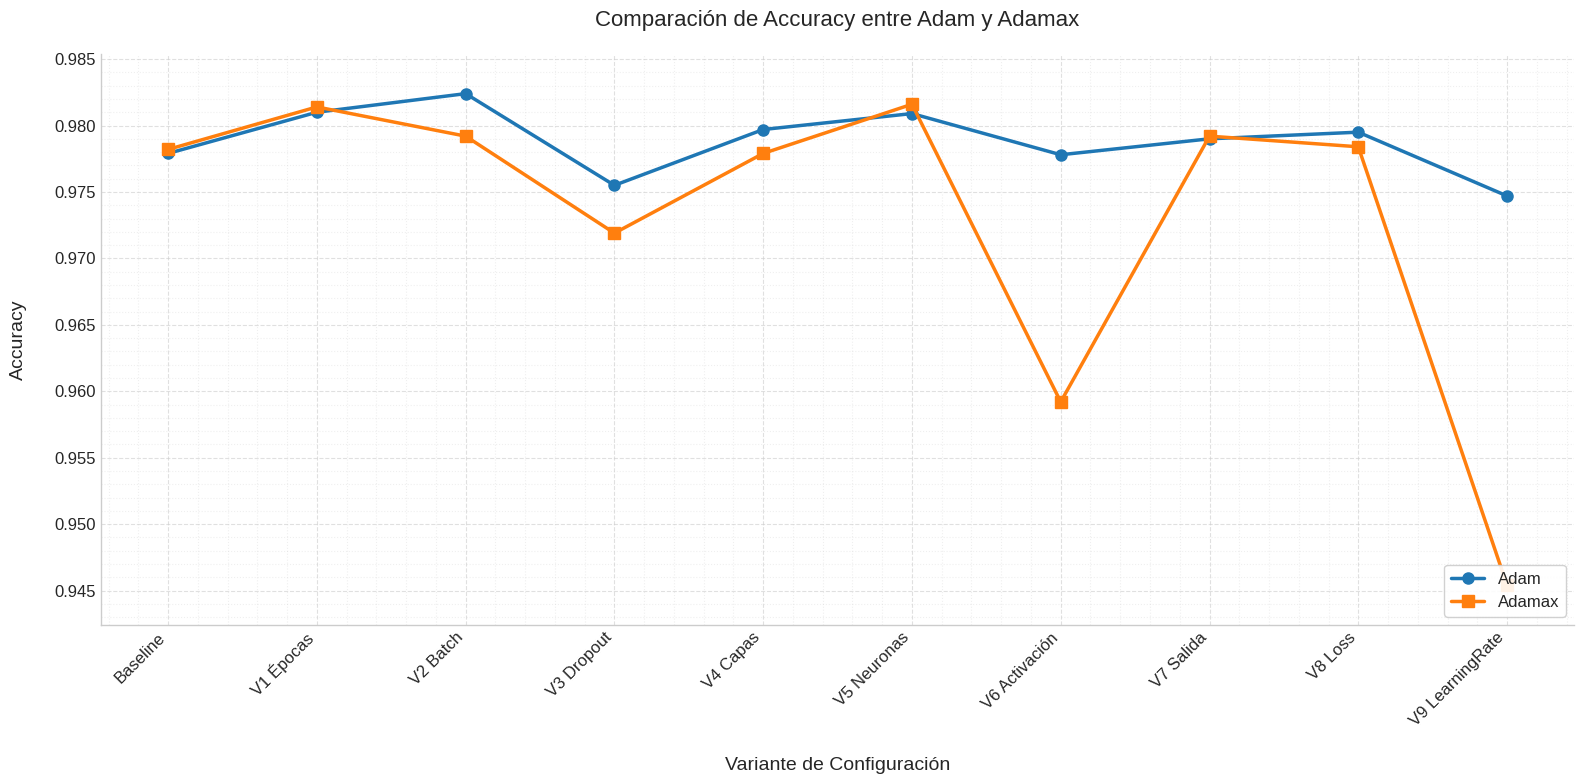

In [ ]:
def visualizar_comparativa_final(resultados_df):
    # Asegurar tipo numérico
    for col in ['Accuracy', 'Precision', 'Recall']:
        resultados_df[col] = resultados_df[col].astype(float)

    # Filtrar y resetear índices
    adam_df   = (resultados_df
                 .query("Modelo.str.contains('Adam') and not Modelo.str.contains('Adamax')", engine='python')
                 .reset_index(drop=True))
    adamax_df = (resultados_df
                 .query("Modelo.str.contains('Adamax')", engine='python')
                 .reset_index(drop=True))

    # Preparar ejes
    variantes = adam_df['Modelo'].str.replace(' Adam$', '', regex=True)
    x = np.arange(len(variantes))
    acc_adam = adam_df['Accuracy'].values
    acc_adamax = adamax_df['Accuracy'].values

    # Estilo general
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'legend.fontsize': 12
    })

    # Figura
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(x, acc_adam,    '-o', linewidth=2.5, markersize=8, label='Adam',   color='#1f77b4')
    ax.plot(x, acc_adamax, '-s', linewidth=2.5, markersize=8, label='Adamax', color='#ff7f0e')

    # Etiquetas y título
    ax.set_xticks(x)
    ax.set_xticklabels(variantes, rotation=45, ha='right')
    ax.set_xlabel('Variante de Configuración', fontsize=14, labelpad=20)
    ax.set_ylabel('Accuracy', fontsize=14, labelpad=20)
    ax.set_title('Comparación de Accuracy entre Adam y Adamax', pad=20)

    # Límites de Y con margen
    ymin = min(acc_adam.min(), acc_adamax.min()) - 0.003
    ymax = max(acc_adam.max(), acc_adamax.max()) + 0.003
    ax.set_ylim(ymin, ymax)

    # Cuadrícula y spines
    ax.grid(which='major', linestyle='--', alpha=0.6)
    ax.minorticks_on()
    ax.grid(which='minor', linestyle=':', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Leyenda
    ax.legend(frameon=True, framealpha=0.9, edgecolor='#CCCCCC', loc='lower right')

    plt.tight_layout()
    plt.show()

# Llamar a la función mejorada
visualizar_comparativa_final(resultados_df)

In [ ]:
# Encontrar el mejor modelo basado en Accuracy
mejor_modelo_index = resultados_df['Accuracy'].astype(float).idxmax()
mejor_modelo = resultados_df.loc[mejor_modelo_index]

print("\n== ANÁLISIS DE RESULTADOS ==")
print(f"El mejor modelo es: {mejor_modelo['Modelo']} con Accuracy de {mejor_modelo['Accuracy']}")

# Comparar optimizadores
adam_mean = resultados_df[resultados_df['Modelo'].str.contains('Adam') & ~resultados_df['Modelo'].str.contains('Adamax')]['Accuracy'].astype(float).mean()
adamax_mean = resultados_df[resultados_df['Modelo'].str.contains('Adamax')]['Accuracy'].astype(float).mean()

print(f"\nPromedio de Accuracy para Adam: {adam_mean:.4f}")
print(f"Promedio de Accuracy para Adamax: {adamax_mean:.4f}")
print(f"Diferencia porcentual: {((adamax_mean - adam_mean) / adam_mean * 100):.2f}%")

# Análisis de variantes
variantes = ['Baseline', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8']
promedios_variantes = []

for variante in variantes:
    mean_acc = resultados_df[resultados_df['Modelo'].str.contains(variante)]['Accuracy'].astype(float).mean()
    promedios_variantes.append(mean_acc)

variante_df = pd.DataFrame({
    'Variante': variantes,
    'Promedio Accuracy': [f'{acc:.4f}' for acc in promedios_variantes]
})

print("\nPromedio de Accuracy por variante:")
print(variante_df)

# Identificar la mejor variante
mejor_variante_index = np.argmax(promedios_variantes)
mejor_variante = variantes[mejor_variante_index]
print(f"\nLa mejor variante es: {mejor_variante} con promedio de Accuracy de {promedios_variantes[mejor_variante_index]:.4f}")


== ANÁLISIS DE RESULTADOS ==
El mejor modelo es: V2 Batch Adam con Accuracy de 0.9824

Promedio de Accuracy para Adam: 0.9788
Promedio de Accuracy para Adamax: 0.9732
Diferencia porcentual: -0.57%

Promedio de Accuracy por variante:
   Variante Promedio Accuracy
0  Baseline            0.9780
1        V1            0.9812
2        V2            0.9808
3        V3            0.9737
4        V4            0.9788
5        V5            0.9812
6        V6            0.9685
7        V7            0.9791
8        V8            0.9789

La mejor variante es: V5 con promedio de Accuracy de 0.9812
